## Compare LaguerreKAN's ability in function interpolation with MLP

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from LaguerreKANLayer import LaguerreKANLayer

In [6]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    return y

In [7]:
alpha_1 = 0
alpha_2 = -0.5
alpha_3 = 3

# Define MLP and LaguerreKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.layers(x)


class LaguerreKAN(nn.Module):
    def __init__(self):
        super(LaguerreKAN, self).__init__()
        self.laguerrekan1 = LaguerreKANLayer(1, 8, 5, alpha_1)
        self.laguerrekan2 = LaguerreKANLayer(8, 10, 3, alpha_2)
        self.laguerrekan3 = LaguerreKANLayer(10, 1, 3, alpha_3)

    def forward(self, x):
        x = self.laguerrekan1(x)
        x = self.laguerrekan2(x)
        x = self.laguerrekan3(x)
        return x

Epoch 1/5000, LaguerreKAN Loss: 6.8426, MLP Loss: 0.5817
Epoch 101/5000, LaguerreKAN Loss: 0.4790, MLP Loss: 0.5126
Epoch 201/5000, LaguerreKAN Loss: 0.2109, MLP Loss: 0.3486
Epoch 301/5000, LaguerreKAN Loss: 0.1932, MLP Loss: 0.2891
Epoch 401/5000, LaguerreKAN Loss: 0.1920, MLP Loss: 0.2662
Epoch 501/5000, LaguerreKAN Loss: 0.1910, MLP Loss: 0.2465
Epoch 601/5000, LaguerreKAN Loss: 0.1890, MLP Loss: 0.2309
Epoch 701/5000, LaguerreKAN Loss: 0.1878, MLP Loss: 0.2186
Epoch 801/5000, LaguerreKAN Loss: 0.1873, MLP Loss: 0.2085
Epoch 901/5000, LaguerreKAN Loss: 0.1869, MLP Loss: 0.2011
Epoch 1001/5000, LaguerreKAN Loss: 0.1862, MLP Loss: 0.1955
Epoch 1101/5000, LaguerreKAN Loss: 0.1856, MLP Loss: 0.1911
Epoch 1201/5000, LaguerreKAN Loss: 0.1850, MLP Loss: 0.1877
Epoch 1301/5000, LaguerreKAN Loss: 0.1843, MLP Loss: 0.1850
Epoch 1401/5000, LaguerreKAN Loss: 0.1830, MLP Loss: 0.1828
Epoch 1501/5000, LaguerreKAN Loss: 0.1815, MLP Loss: 0.1811
Epoch 1601/5000, LaguerreKAN Loss: 0.1800, MLP Loss:

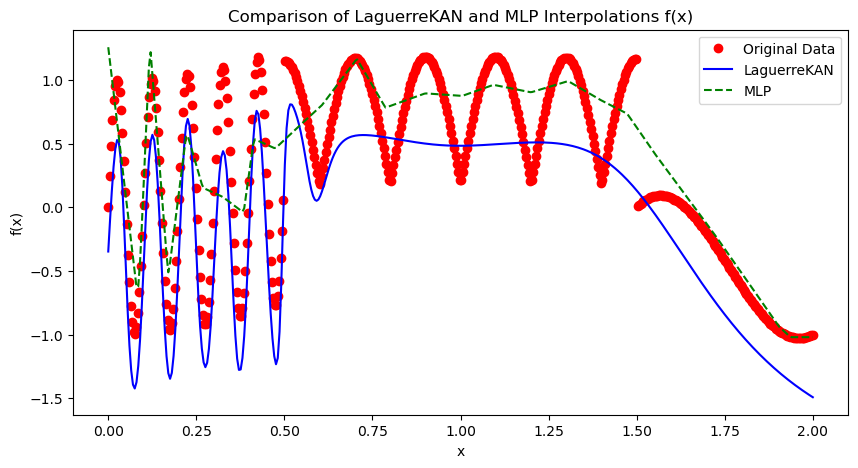

In [8]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
laguerre_model = LaguerreKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_laguerre = torch.optim.Adam(laguerre_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.015)

# Train the models
epochs = 5000
for epoch in range(epochs):
    optimizer_laguerre.zero_grad()
    outputs_laguerre = laguerre_model(x_train)
    loss_laguerre = criterion(outputs_laguerre, y_train)
    loss_laguerre.backward()
    optimizer_laguerre.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, LaguerreKAN Loss: {loss_laguerre.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_laguerre = laguerre_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_laguerre.numpy(), 'b-', label='LaguerreKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of LaguerreKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()